In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

In [19]:
def load_data():
    pre_data_list = []
    for i in range(40):
        filename = f'testdata/pre-{i:02}.csv'
        data = pd.read_csv(filename, header=None)
        pre_data_list.append(data)
    rear_data_list = []
    for i in range(5):
        filename = f'testdata/rear-{i}.csv'
        data = pd.read_csv(filename, header=None)
        rear_data_list.append(data)       
    return pre_data_list, rear_data_list

pre_data_list, rear_data_list = load_data()

In [20]:
def resample_time_series(df, frequency='T'):
    df['Time'] = pd.to_datetime(df.iloc[:, 0])  # 假设第一列是时间
    df = df.set_index('Time')
    df_resampled = df.resample(frequency).mean().interpolate()  # 重采样并插值
    return df_resampled

# 应用到每个批次
resampled_batches = [resample_time_series(batch) for batch in pre_data_list + rear_data_list]

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39622/972890733.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(frequency).mean().interpolate()  # 重采样并插值
/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39622/972890733.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(frequency).mean().interpolate()  # 重采样并插值
/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39622/972890733.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(frequency).mean().interpolate()  # 重采样并插值
/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39622/972890733.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(frequency).mean().interpolate()  #

In [21]:
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    data_stacked = np.stack([batch.iloc[:, 1:].values for batch in data])  # 假设除第一列外都是数据列
    data_reshaped = data_stacked.reshape(-1, data_stacked.shape[2])  # 调整形状适应PCA
    principal_components = pca.fit_transform(data_reshaped)
    return principal_components, pca

principal_components, pca = apply_pca(resampled_batches)

In [22]:
from tslearn.clustering import TimeSeriesKMeans

# 假设我们对PCA结果进行聚类
def perform_clustering(data, n_clusters=2):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=100)
    labels = model.fit_predict(data.reshape(-1, data.shape[1], 1))  # 注意数据形状
    return labels

# 假设 principal_components 已经定义
labels = perform_clustering(principal_components, n_clusters=3)  # 尝试将簇数量设置为3

/Users/ysrae1/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ysrae1/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ysrae1/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ysrae1/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ysrae1/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK U

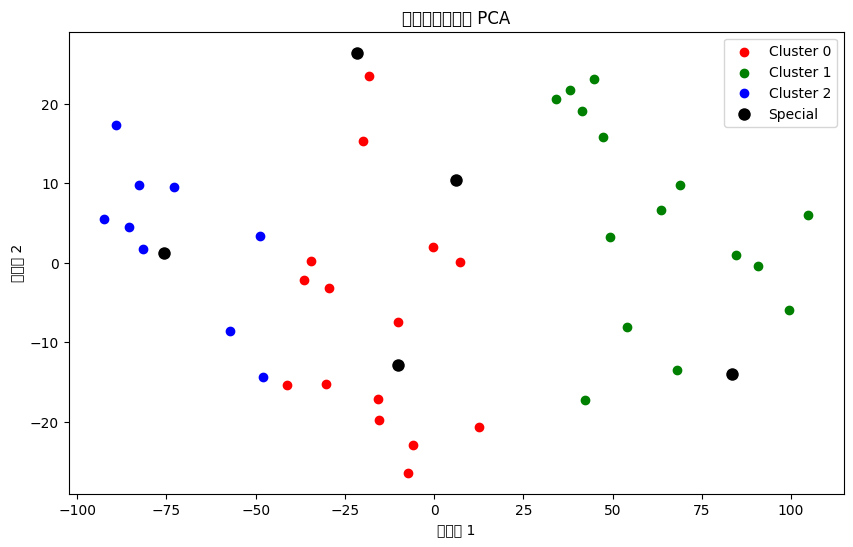

In [23]:
def plot_clusters(data, labels, special_indices=None):
    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b', 'y', 'c', 'm']  # 基本颜色列表
    num_clusters = np.unique(labels).size
    if num_clusters > len(colors):
        colors *= (num_clusters // len(colors)) + 1

    seen_labels = set()
    for i in range(data.shape[0]):
        color = colors[labels[i]]
        label = f'Cluster {labels[i]}'
        if label not in seen_labels:
            plt.scatter(data[i, 0], data[i, 1], color=color, label=label)
            seen_labels.add(label)
        else:
            plt.scatter(data[i, 0], data[i, 1], color=color)

    # 特别突出显示特定索引的点
    if special_indices is not None:
        for index in special_indices:
            plt.scatter(data[index, 0], data[index, 1], color='black', edgecolor='white', s=100, label='Special' if 'Special' not in seen_labels else "", zorder=5)
            seen_labels.add('Special')

    plt.xlabel('主成分 1')
    plt.ylabel('主成分 2')
    plt.title('时间序列数据的 PCA')
    plt.legend()
    plt.show()

# 假设 principal_components 和 labels 已经定义
# 假设特殊数据点的索引已知，比如最后五个点
special_indices = [len(principal_components) - i - 1 for i in range(5)]
plot_clusters(principal_components, labels, special_indices=special_indices)